# References:
### Global Investigation of Return Autocorrelation and Its Determinants
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2963414

//return autocorrelation is significantly larger in emerging markets than in developed markets.//

### Time Series Analysis Using ARIMA Model In R
https://datascienceplus.com/time-series-analysis-using-arima-model-in-r/
### Formal ways to compare forecasting models: Rolling windows
https://www.r-bloggers.com/formal-ways-to-compare-forecasting-models-rolling-windows/
### construct an appropriate time series model
http://rstudio-pubs-static.s3.amazonaws.com/248109_7aba6341a24f4da5853613830f3e71b1.html
### Autoregressive Moving Average ARMA(p, q) Models for Time Series Analysis - Part 3
https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-3/

# Getting started

In [19]:
pwd()

[1] "C:/Users/Chan WingYiu/Documents/ECON3283 Economic Forecasting/Project"

In [18]:
# install.packages("arfima")

Installing package into 'C:/Users/Chan WingYiu/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'arfima' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Public\Documents\Wondershare\CreatorTemp\Rtmp213gUA\downloaded_packages


In [23]:
### Load packages
library(data.table)
library(readxl)
library(stringr)
library(dplyr)
library(forecast)
library(ggplot2)
library(tseries)
library(stats)
library(psych)
library(fUnitRoots)
library(lmtest)
library(pastecs)
library(FitAR)
library(aTSA)
library(itsmr)
library(pracma)
library(arfima)
library(dse)
library(smooth)
library(fGarch)

In [3]:
list.files(pattern = ".csv")

[1] "^GSPC.csv"     "^NZ50.csv"     "^STOXX50E.csv" "000001.SS.csv"

# Stock 1 
## About S&P/NZX 50 Gross Index
The New Zealand Exchange 50 Gross Index is a modified market capitalization weighted index. This index consists of the top 50 companies by free float adjusted market capitalization that are listed on the New Zealand Exchange Limited. (Bloomberg)

As we all know, the return of HSI is a white noise. By Market Efficency Hypothesis, it is possible that HSI is too exploited, as it is too frequenly traded by investors. In fact, its 30 day average volume is 1,774,525,972 (Bloomberg). Conversely, the New Zealand Exchange 50 Gross Index is only having a 49,914,886 30 day average volume. It is believed that it is a less efficient market, thus may show more autocorrelation in data.
## Inspecting the data

In [4]:
# Load data

df = read.csv('^NZ50.csv')
df %>% setDT
df = df[,.(date = as.Date(Date),
                 Price = Adj.Close%>% as.character %>% as.numeric)]
df = df[date>='2019-05-04' & date <= '2020-05-08',]
df = na.omit(df)
setkey(df, date)
df %>% tail

Warning message in function_list[[k]](value):
"NAs introduced by coercion"


date,Price
<date>,<dbl>
2020-05-01,10449.01
2020-05-04,10516.09
2020-05-05,10551.16
2020-05-06,10596.77
2020-05-07,10676.25
2020-05-08,10695.59


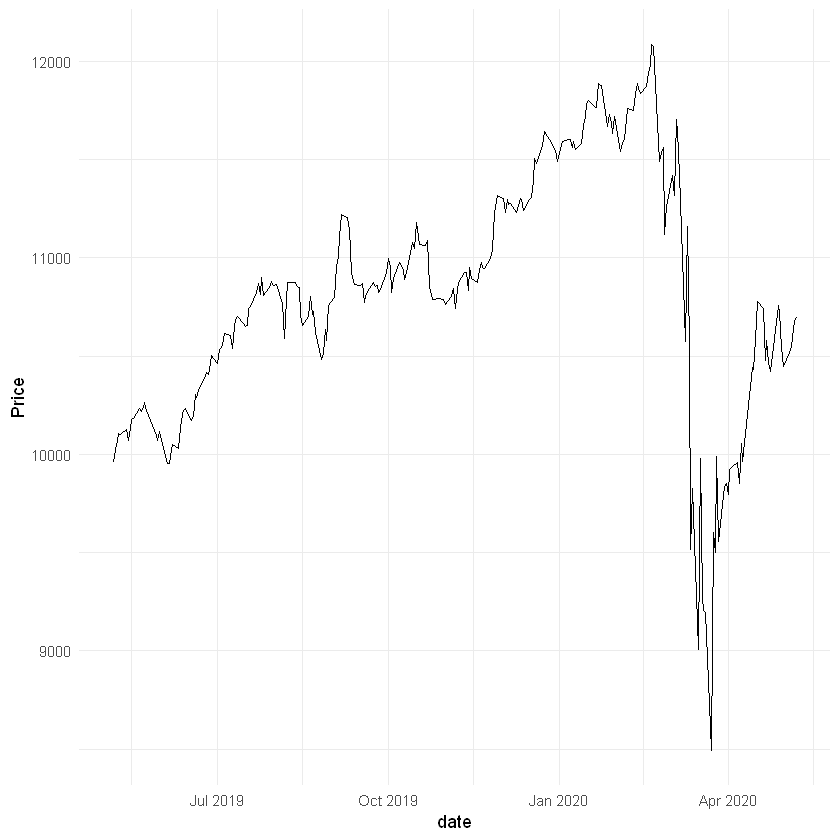

In [5]:
# Graph of the index

ggplot(df, aes(x=date)) + geom_line(aes(y=Price,group=1))+ theme_minimal()

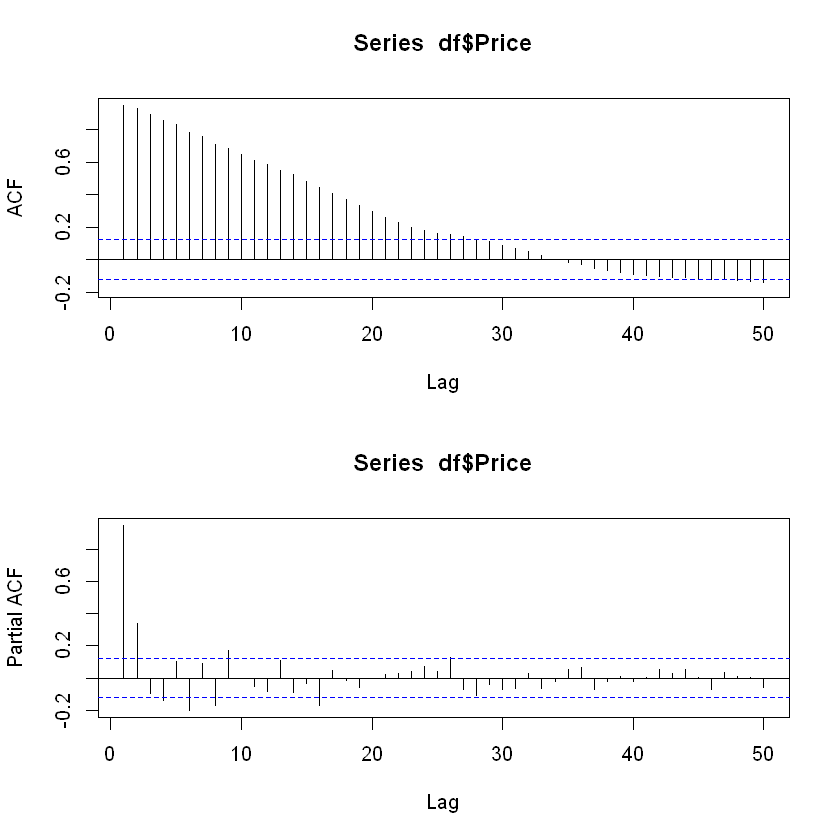

In [6]:
# ACFs and PACFs 
par(mfrow=c(2,1))

Acf(df$Price, lag.max = 50)

Pacf(df$Price, lag.max = 50)

Obviously, the time series data is non-stationary. So, we need to use log differences to make it mean stationary:
$R_t = log(P_t) - log(P_{t-1})$

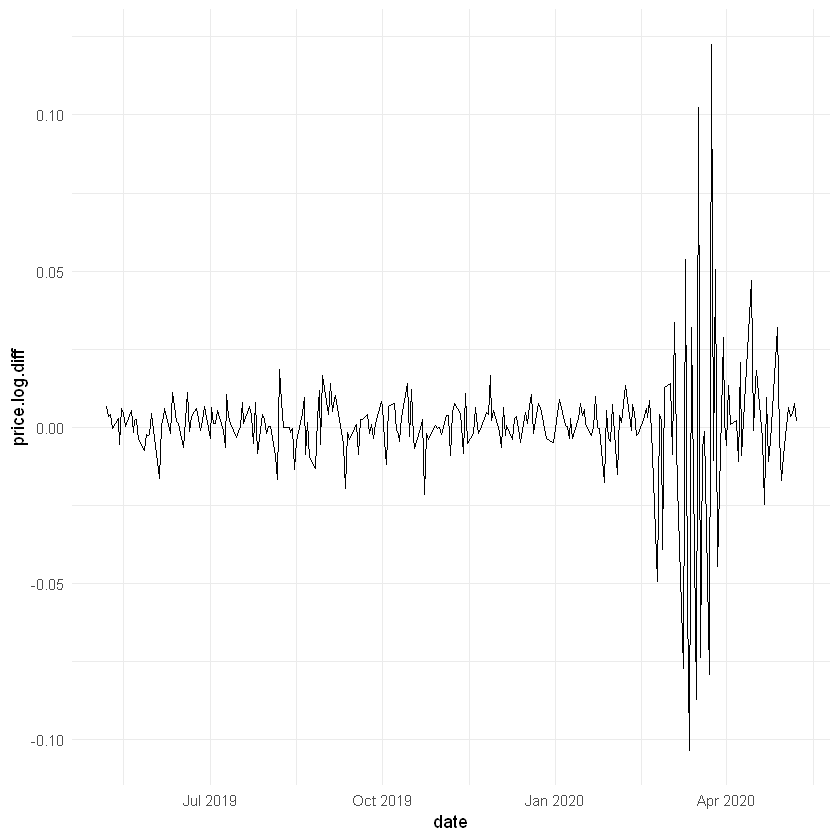

In [7]:
df[, price.lag.1:= shift(Price, type = 'lag', n=1) ]
df[, price.log.diff := log(Price) - log(price.lag.1)]
df = na.omit(df)
ggplot(df, aes(x=date)) + geom_line(aes(y=price.log.diff,group=1))+ theme_minimal() 

In [8]:
# Descriptive statistics 

stat.desc(df$price.log.diff)

nbr.val      nbr.null        nbr.na           min           max 
 2.540000e+02  0.000000e+00  0.000000e+00 -1.033731e-01  1.225738e-01 
        range           sum        median          mean       SE.mean 
 2.259469e-01  7.119216e-02  1.126160e-03  2.802841e-04  1.212098e-03 
 CI.mean.0.95           var       std.dev      coef.var 
 2.387088e-03  3.731722e-04  1.931767e-02  6.892173e+01

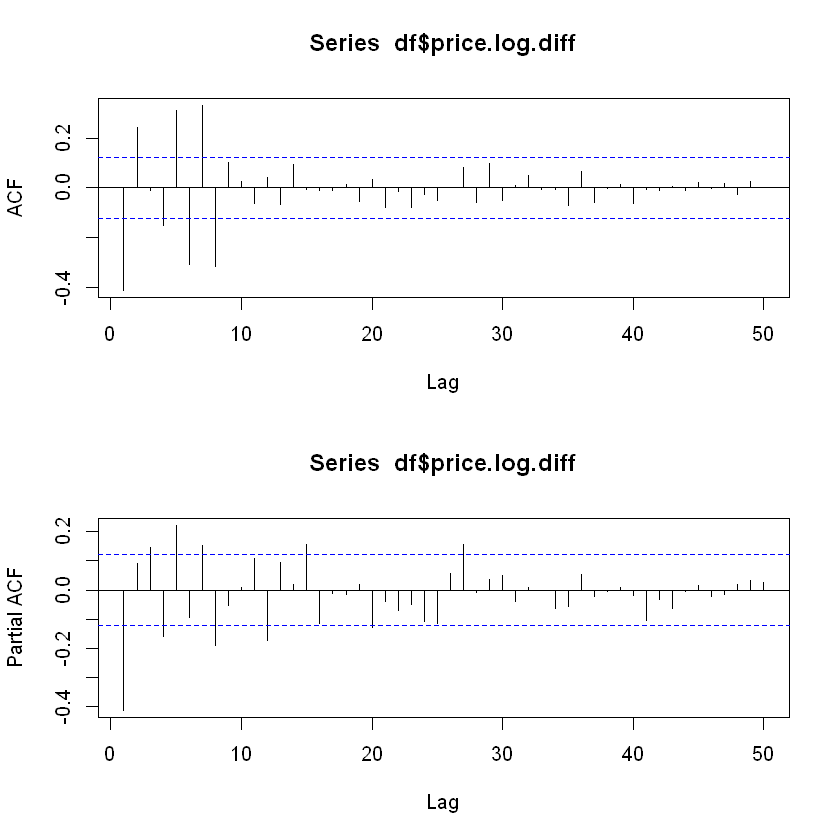

In [9]:
# ACFs and PACFs 
par(mfrow=c(2,1))

Acf(df$price.log.diff, lag.max = 50)

Pacf(df$price.log.diff, lag.max = 50)

In [24]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$price.log.diff, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -24.60    0.01
[2,]   1 -12.14    0.01
[3,]   2  -8.29    0.01
[4,]   3  -8.59    0.01
[5,]   4  -5.99    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -24.56    0.01
[2,]   1 -12.12    0.01
[3,]   2  -8.28    0.01
[4,]   3  -8.57    0.01
[5,]   4  -5.98    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -24.55    0.01
[2,]   1 -12.13    0.01
[3,]   2  -8.28    0.01
[4,]   3  -8.59    0.01
[5,]   4  -5.98    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


The return is seems mean stationary, however, is obviously variance non-stationary from the plot. From the Augmented Dickey-Fuller test, the coefficients are all negative in the three types of test, and the p-value is smaller than 0.01, indicating the data do not have unit root and is stationary. From the ACF graph, it has spikes on the first few lags, and then a decay toward zero; PACF shows splike from first lag and a smooth decay toward zero. These are signs that the time zeries may be an ARMA process.

## Model Selection

In [28]:
# prepare ts data

df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
print(paste("Number of observations:",length(tsdata)))

[1] "Number of observations: 249"


In [29]:
#  fitting different ARMA models and compare with AIC

auto.arima(tsdata, trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)             with non-zero mean : -1327.669
 ARIMA(0,0,0)             with non-zero mean : -1251.14
 ARIMA(1,0,0)             with non-zero mean : -1294.763
 ARIMA(0,0,1)             with non-zero mean : -1282.902
 ARIMA(0,0,0)             with zero mean     : -1253.148
 ARIMA(1,0,2)             with non-zero mean : -1296.429
 ARIMA(2,0,1)             with non-zero mean : -1293.807
 ARIMA(3,0,2)             with non-zero mean : -1331.181
 ARIMA(3,0,1)             with non-zero mean : -1331.468
 ARIMA(3,0,0)             with non-zero mean : -1296.21
 ARIMA(4,0,1)             with non-zero mean : -1329.683
 ARIMA(2,0,0)             with non-zero mean : -1293.813
 ARIMA(4,0,0)             with non-zero mean : -1299.713
 ARIMA(4,0,2)             with non-zero mean : -1327.752
 ARIMA(3,0,1)             with zero mean     : -1333.553
 ARIMA(2,0,1)             with zero mean     : -1295.877
 ARIMA(3,0,0)             wit

Series: tsdata 
ARIMA(3,0,1) with zero mean 

Coefficients:
          ar1      ar2    ar3     ma1
      -1.1728  -0.1242  0.275  0.9262
s.e.   0.0638   0.0968  0.062  0.0254

sigma^2 estimated as 0.000267:  log likelihood=672.45
AIC=-1334.9   AICc=-1334.65   BIC=-1317.31

Using AIC as model selection criterion, the best model estimated is ARMA(3,1)

#### ARMA(3,1)

In [30]:
fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error  z value  Pr(>|z|)    
ar1       -1.17306032  0.06384683 -18.3730 < 2.2e-16 ***
ar2       -0.12464305  0.09684232  -1.2871    0.1981    
ar3        0.27479133  0.06198933   4.4329 9.298e-06 ***
ma1        0.92620773  0.02541507  36.4433 < 2.2e-16 ***
intercept  0.00018827  0.00097931   0.1923    0.8475    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [31]:
coefficients(fitARIMA)

ar1           ar2           ar3           ma1     intercept 
-1.1730603218 -0.1246430535  0.2747913254  0.9262077325  0.0001882747

In [32]:
confint(fitARIMA)

,2.5 %,97.5 %
ar1,-1.298197801,-1.047922843
ar2,-0.314450516,0.065164409
ar3,0.153294481,0.396288170
ma1,0.876395117,0.976020348
intercept,-0.001731147,0.002107696


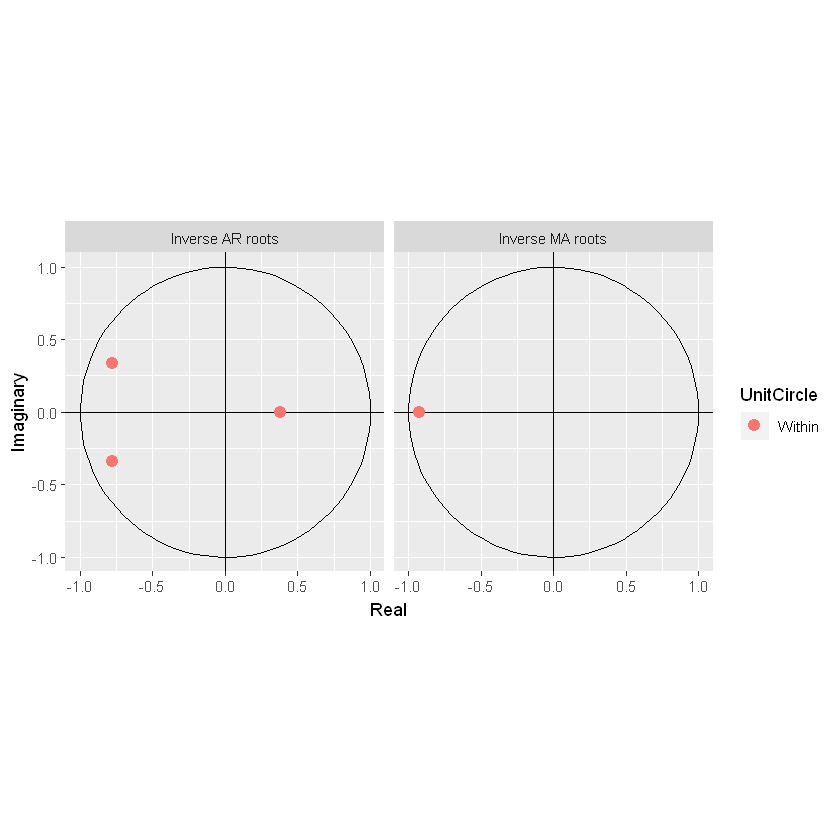

In [33]:
autoplot(fitARIMA)

Although ARMA(3,1) has the lowest AIC, and is stationary and invertible, not all its coefficients are statistically significant. Therefore, we would take a look at other models with comparable AIC.

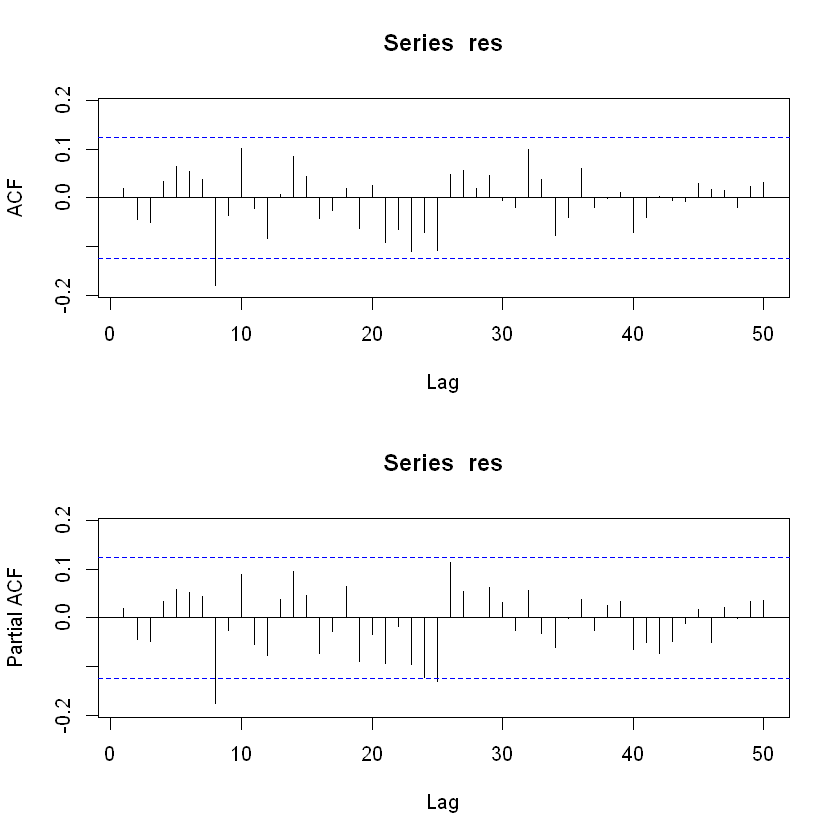

In [34]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

In [35]:
#  Ljung-Box Test
Box.test(res, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  res
X-squared = 45.238, df = 50, p-value = 0.6646


Since p-value > 0.05, it means the residuals are independent at 95% level, thus ARMA(3,1) is a good fit


	Ljung-Box test

data:  Residuals from ARIMA(3,0,1) with non-zero mean
Q* = 45.238, df = 45, p-value = 0.462

Model df: 5.   Total lags used: 50



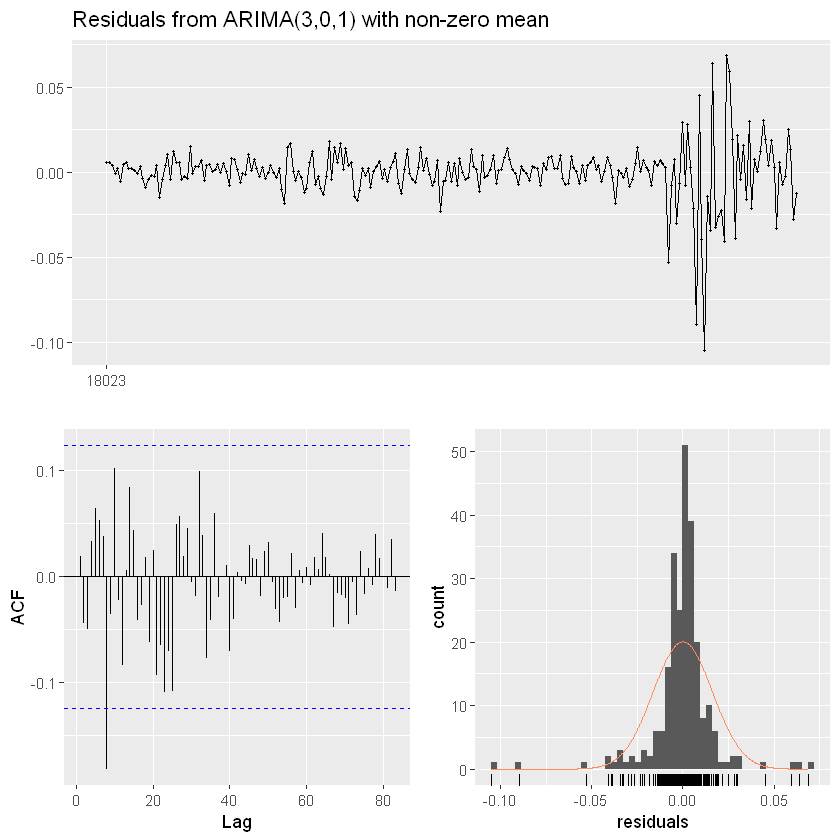

In [36]:
checkresiduals(fitARIMA)

#### ARMA(3,2)

In [37]:
fitARIMA <- arima(tsdata, order=c(3,0,2),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value  Pr(>|z|)    
ar1       -1.46814365  0.20410174 -7.1932 6.329e-13 ***
ar2       -0.51788489  0.28911340 -1.7913   0.07325 .  
ar3        0.13216630  0.12449292  1.0616   0.28840    
ma1        1.24604893  0.20179328  6.1749 6.621e-10 ***
ma2        0.30808172  0.19128706  1.6106   0.10727    
intercept  0.00019714  0.00091761  0.2148   0.82989    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [38]:
coef = coefficients(fitARIMA)
IdentInvertQ(phi = c(coef['ar1'], coef['ar2'], coef['ar3']), theta = c(coef['ma1']))

[1] FALSE

#### ARMA(2,2)

In [39]:
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error  z value  Pr(>|z|)    
ar1       -1.66567942  0.05823392 -28.6033 < 2.2e-16 ***
ar2       -0.81154472  0.05377596 -15.0912 < 2.2e-16 ***
ma1        1.42053031  0.08823512  16.0994 < 2.2e-16 ***
ma2        0.47108322  0.08484572   5.5522  2.82e-08 ***
intercept  0.00020262  0.00085506   0.2370    0.8127    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


All coefficients are statistically significant.

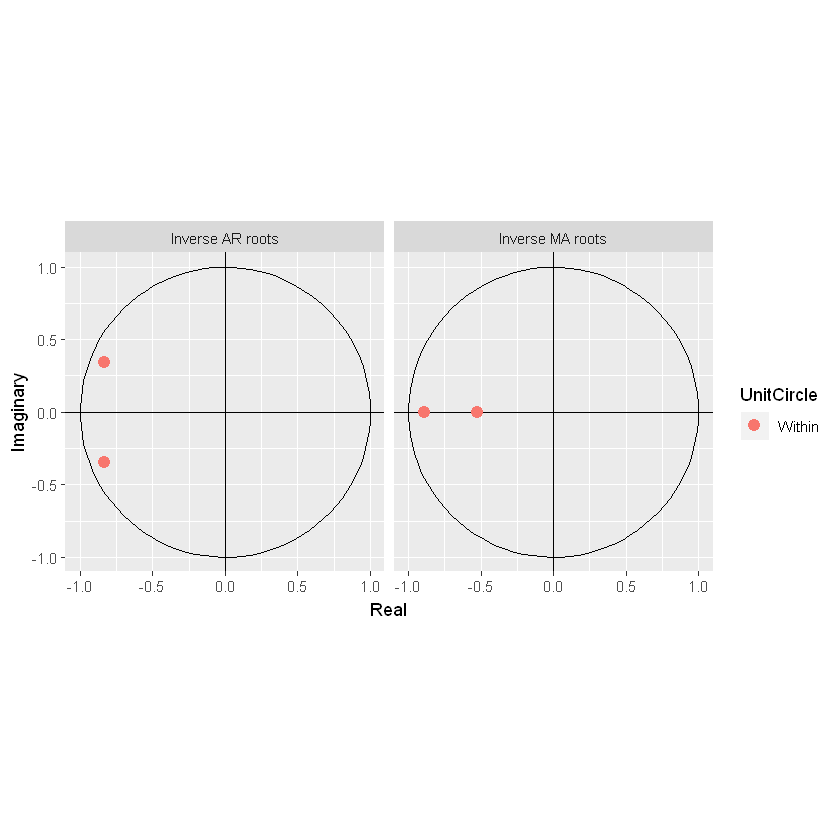

In [40]:
autoplot(fitARIMA)

All roots lie inside unit circle, showing the model is stationary and invertible.


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with non-zero mean
Q* = 43.438, df = 45, p-value = 0.5383

Model df: 5.   Total lags used: 50



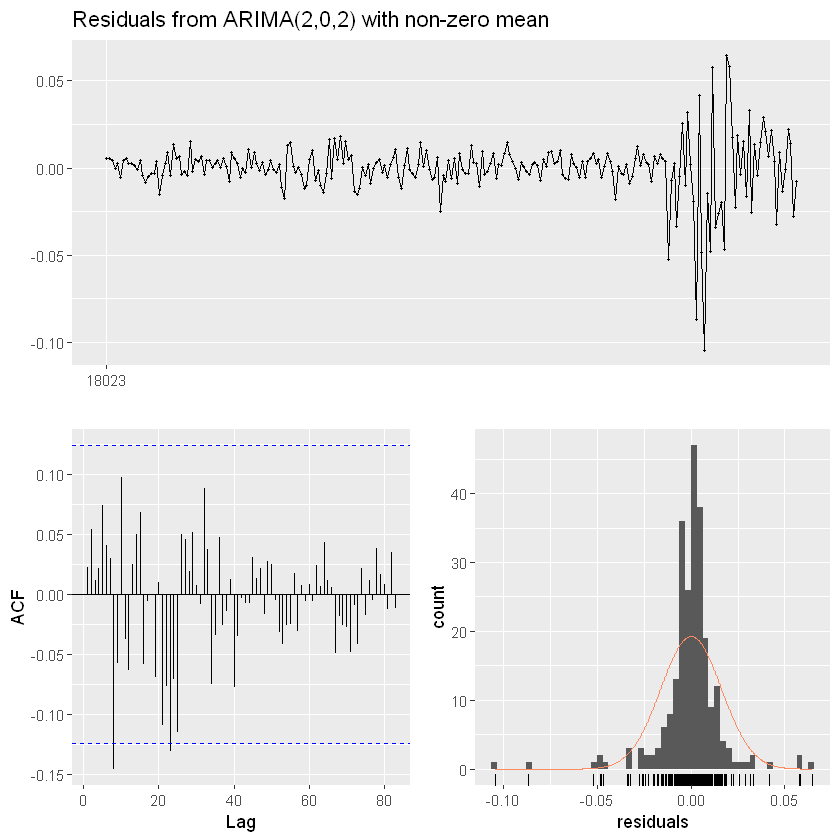

In [42]:
checkresiduals(fitARIMA)

Since p-value > 0.05, we fail to reject the null hypothesis that all autocorrelations up to order 50 are equal to zero, meaning the residuals are independent at 95% level. Thus, ARMA(2,2) is a good fit as the residuals are seemingly white noise. However, it is obvious from the plot that the residuals have time-varying volatility.

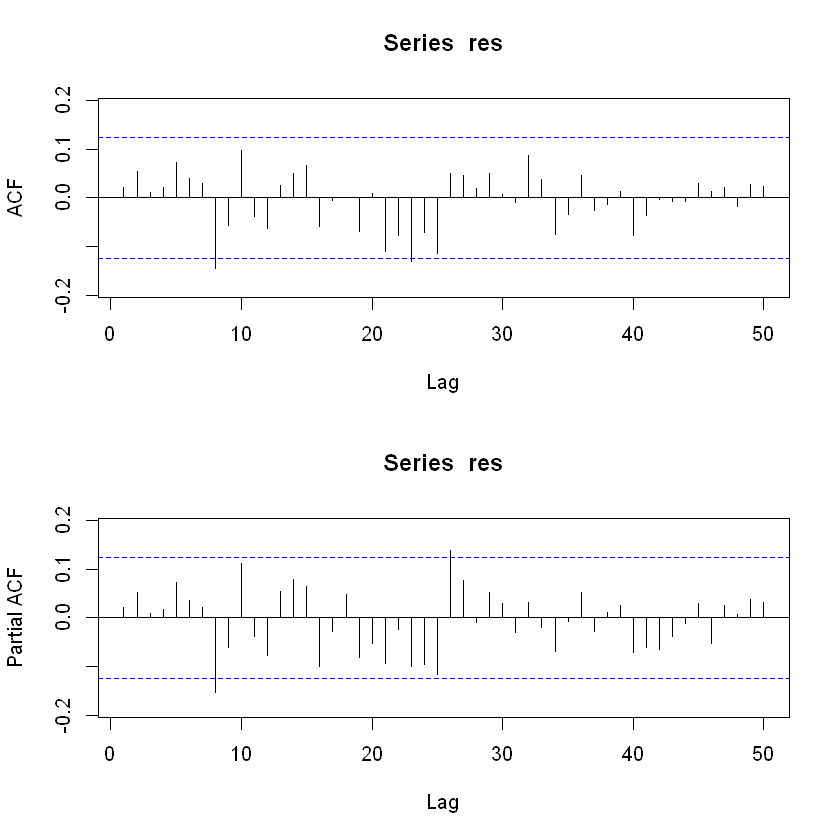

In [43]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

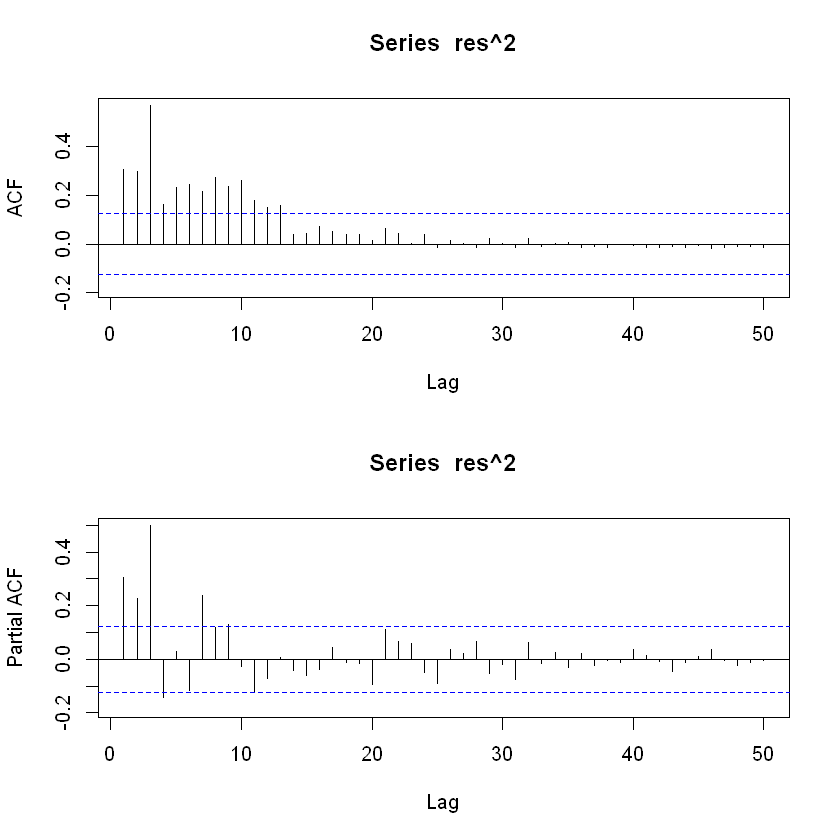

In [44]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res^2, lag.max = 50)

Pacf(res^2, lag.max = 50)

From the ACF and PACF plot of squared residuals, we can see the residuals exhibit time-varying volatility as it has autocorrelations. Therefore, we would use GARCH model to predict the volatility.

#### ARMA(3,0)

In [144]:
fitARIMA <- arima(tsdata, order=c(3,0,0),method="ML")
coeftest(fitARIMA)


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ar1       -0.3872109  0.0626369 -6.1818 6.336e-10 ***
ar2        0.1448684  0.0668144  2.1682   0.03014 *  
ar3        0.1456109  0.0625598  2.3275   0.01994 *  
intercept  0.0001792  0.0010097  0.1775   0.85914    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [145]:
coef = coefficients(fitARIMA)
IdentInvertQ(phi = c(coef['ar1'], coef['ar2'], coef['ar3']), theta = numeric(0))

[1] TRUE

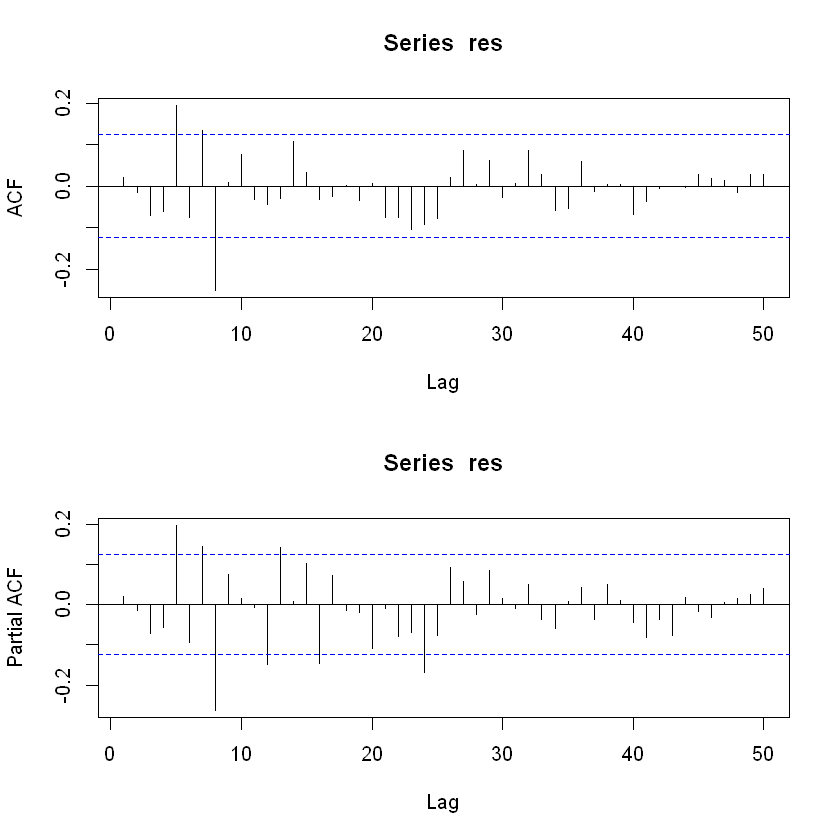

In [146]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

In [147]:
#  Ljung-Box Test
Box.test(res, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  res
X-squared = 63.063, df = 50, p-value = 0.1016


#### ARMA(2,1)

In [148]:
fitARIMA <- arima(tsdata, order=c(2,0,1),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error z value Pr(>|z|)   
ar1        0.17112019  0.27735844  0.6170 0.537258   
ar2        0.32740357  0.10962359  2.9866 0.002821 **
ma1       -0.54740952  0.28537747 -1.9182 0.055086 . 
intercept  0.00018804  0.00100575  0.1870 0.851685   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [149]:
coef = coefficients(fitARIMA)
IdentInvertQ(phi = c(coef['ar1'], coef['ar2']), theta = c(coef['ma1']))

[1] TRUE

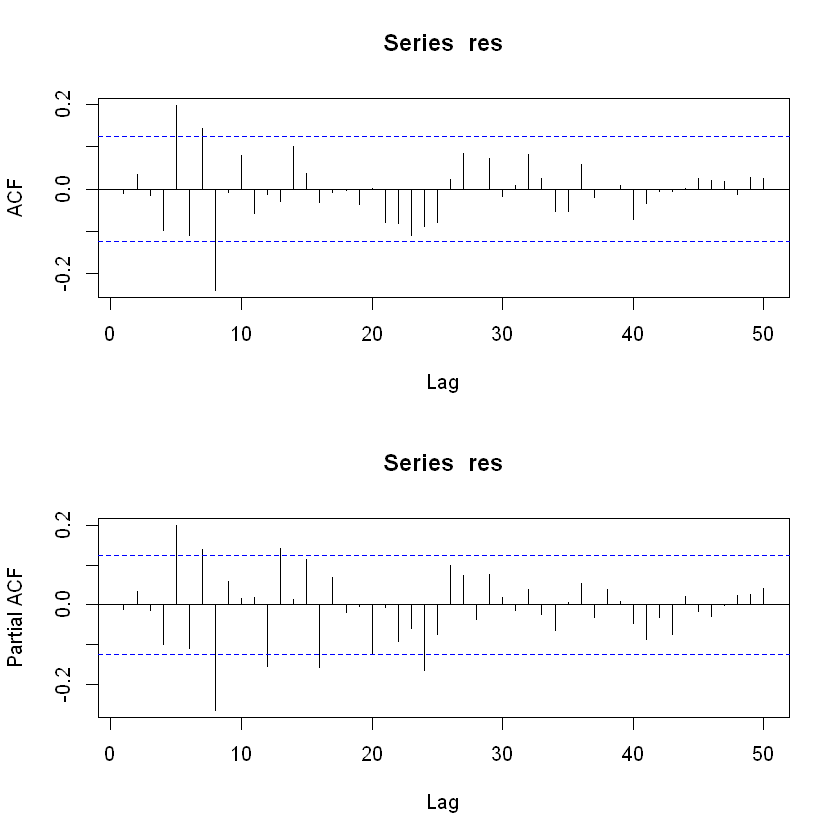

In [150]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

In [151]:
#  Ljung-Box Test
Box.test(res, lag = 50, type = "Ljung-Box")


	Box-Ljung test

data:  res
X-squared = 65.368, df = 50, p-value = 0.07107


## Forecast with rolling scheme

#### Forecast for May 4:

In [152]:
df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 250) 
End = c(18023, 250) 
Frequency = 365 
[1] 0.005384866

$se
Time Series:
Start = c(18023, 250) 
End = c(18023, 250) 
Frequency = 365 
[1] 0.01617198

In [153]:
# Manual calculation of one-step ahead forecast for May 4:
ar1 = coef(fitARIMA)['ar1']
ar2 = coef(fitARIMA)['ar2']
# ar3 = coef(fitARIMA)['ar3']
ma1 = coef(fitARIMA)['ma1']
ma2 = coef(fitARIMA)['ma2']
mu = coef(fitARIMA)['intercept']
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t = res[length(res)-0]
eps.t.1 = res[length(res)-1]
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.4 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  0.00538486581613136"


In [154]:
y.truth = df[date == "2020-05-04", list(date, price.log.diff)]$price.log.diff
y.4 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
e.4 = eps.t.update
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00639923569738876"
[1] "The forecast error is: 0.0010143698812574"



Call:
garch(x = y, order = c(1, 1), trace = FALSE)

Model:
GARCH(1,1)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6059 -0.4830  0.1643  0.5865  1.9551 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 8.276e-06   3.139e-06    2.636  0.00838 ** 
a1 1.034e-01   2.972e-02    3.481  0.00050 ***
b1 8.139e-01   5.960e-02   13.656  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 801.26, df = 2, p-value < 2.2e-16


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.056589, df = 1, p-value = 0.812


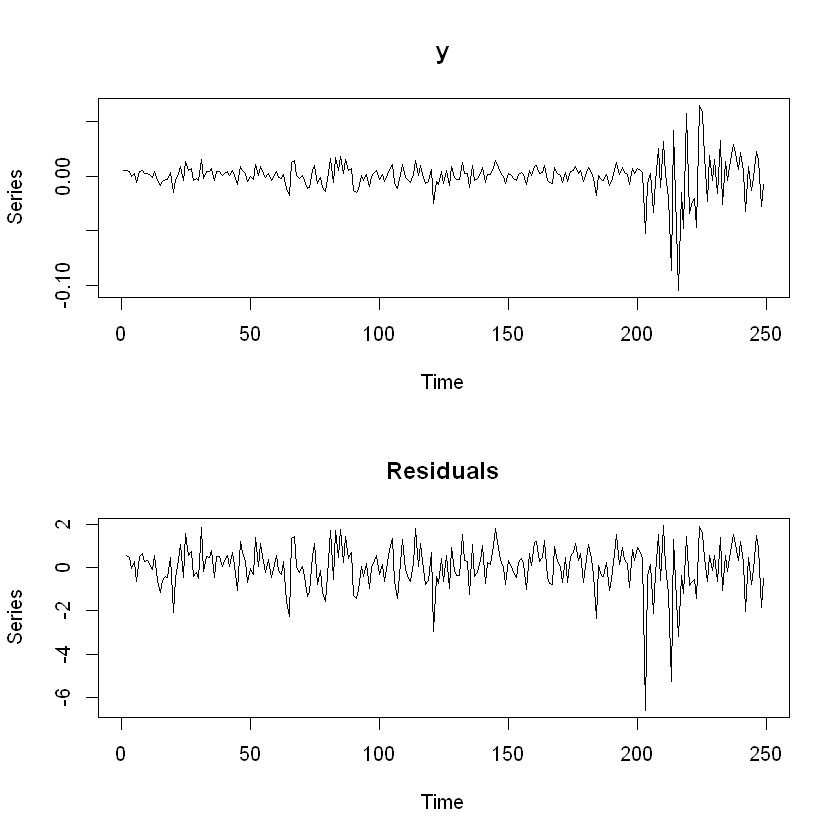

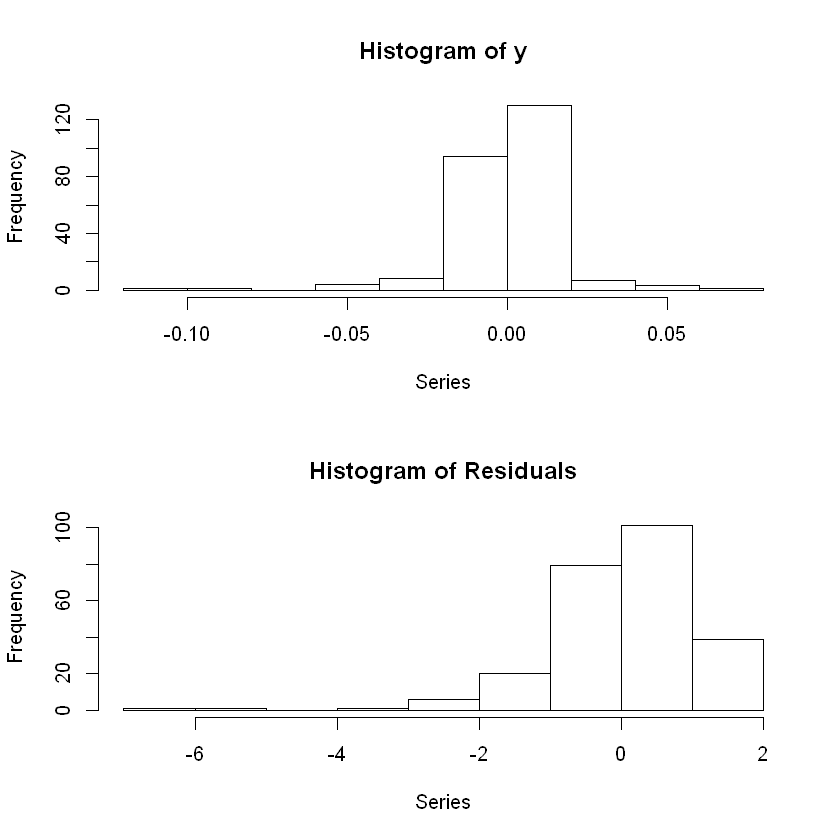

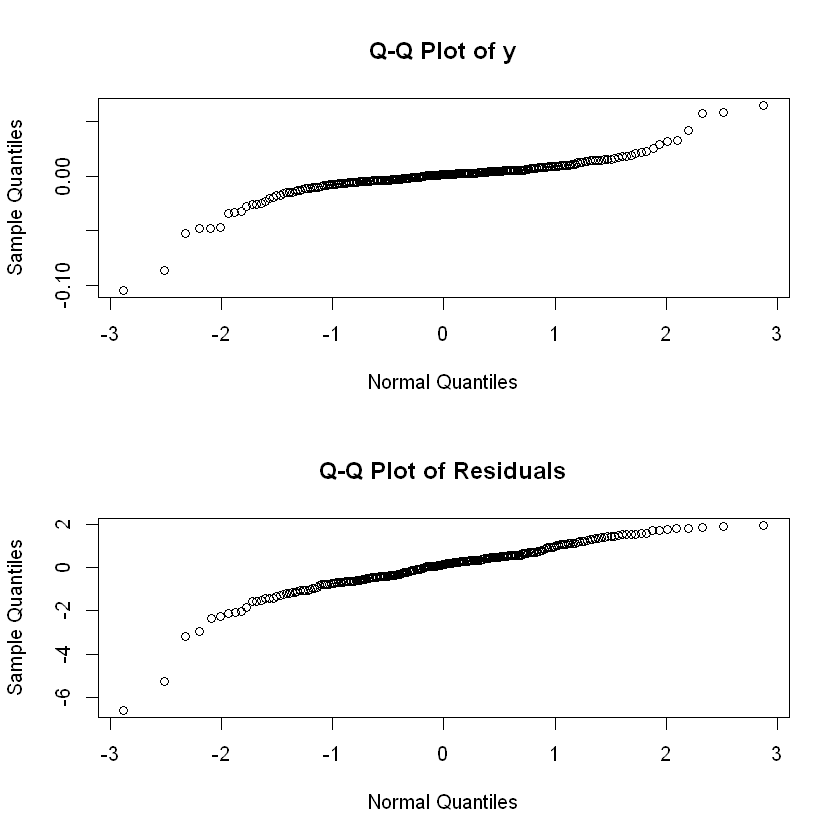

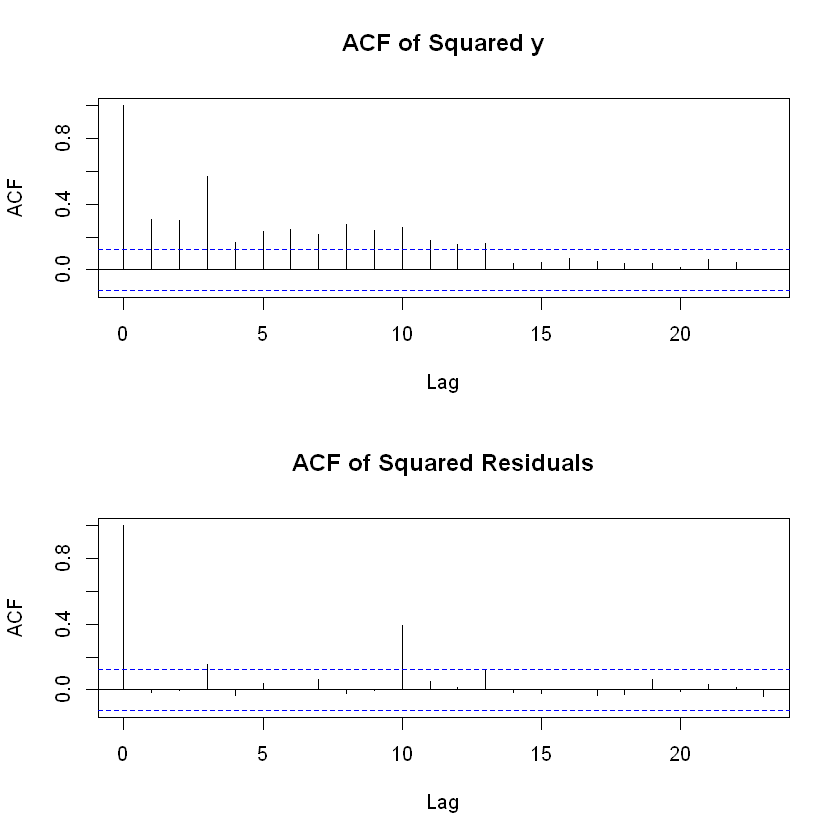

In [155]:
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
summary(garch.y)                     # Diagnostic tests

plot(garch.y)

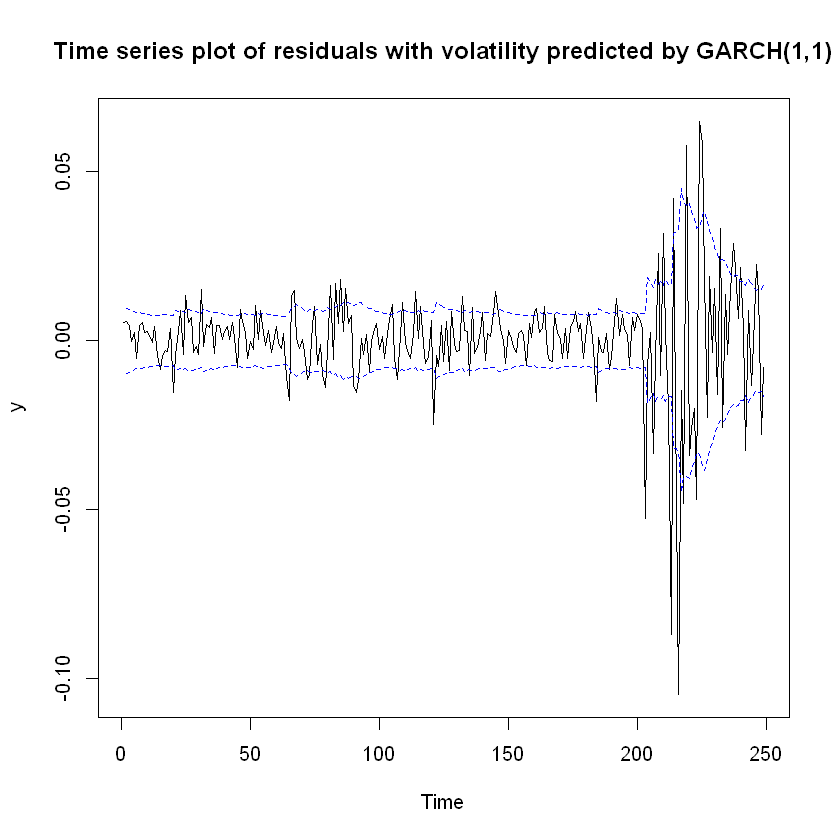

In [156]:
u = predict(garch.y)
u = u %>% na.omit
plot(y, type="l", xlab="Time", main = "Time series plot of residuals with volatility predicted by GARCH(1,1)")
lines(u[,1], col="blue", lty="dashed")
lines(u[,2], col="blue", lty="dashed")

In [157]:
fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
omega = coef(fit)[2]
print(paste("omega:",omega))
alpha = coef(fit)[3]
print(paste("alpha",alpha))
beta = coef(fit)[4]
print(paste("beta",beta))
sigma.t = last(volatility(fit))
print(paste("sigma_{t|t-1}:",sigma.t))
epsilon.t = last(residuals(fit))
print(paste("epsilon_t:",epsilon.t))
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.4 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "omega: 8.01794395483014e-06"
[1] "alpha 0.21193207718508"
[1] "beta 0.757502059125593"
[1] "sigma_{t|t-1}: 0.0196626869690167"
[1] "epsilon_t: -0.00797343094436574"
[1] "1 step ahead forecast sigma: 0.0177301453127844"


In [158]:
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.534721e-05,0.01773015,0.01773015


In [159]:
lower.ci = f.1 - 1.96 * sigma
upper.ci = f.1 + 1.96 * sigma
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: 0.00476872403261895"
[1] "Prediction upper bound: 0.00600100759964376"
[1] "The truth value is:  0.00639923569738876"


#### Forecast for May 5:

In [160]:
# Manual calculation of one-step ahead forecast for May 5:
# ar1 = coef(fitARIMA)['ar1']
# ar2 = coef(fitARIMA)['ar2']
# # ar3 = coef(fitARIMA)['ar3']
# ma1 = coef(fitARIMA)['ma1']
# ma2 = coef(fitARIMA)['ma2']
# mu = coef(fitARIMA)['intercept']
df.ts = df[ date < '2020-05-05', list(date, price.log.diff)]
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t.1 = eps.t
eps.t = eps.t.update
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.5 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  -0.00483124316198762"


In [161]:
epsilon.t = eps.t.update
sigma.t = sigma^(1/2)
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.5 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "1 step ahead forecast sigma: 0.0156959511651993"


In [162]:
lower.ci = f.1 - 1.96 * sigma
upper.ci = f.1 + 1.96 * sigma
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.00531411441262905"
[1] "Prediction upper bound: -0.00434837191134619"
[1] "The truth value is:  0.00639923569738876"


In [163]:
y.truth = df[date == "2020-05-05", list(date, price.log.diff)]$price.log.diff
y.5 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00332937088565011"
[1] "The forecast error is: 0.00816061404763772"


Double verifying with function:

In [164]:
# Double verifying with function:

# df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 251) 
End = c(18023, 251) 
Frequency = 365 
[1] -0.004829689

$se
Time Series:
Start = c(18023, 251) 
End = c(18023, 251) 
Frequency = 365 
[1] 0.0161397

In [165]:
res = residuals(fitARIMA)
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.949742e-05,0.01561543,0.01561543


#### Forecast for May 6:

In [166]:
# Manual calculation of one-step ahead forecast for May 5:
# ar1 = coef(fitARIMA)['ar1']
# ar2 = coef(fitARIMA)['ar2']
# # ar3 = coef(fitARIMA)['ar3']
# ma1 = coef(fitARIMA)['ma1']
# ma2 = coef(fitARIMA)['ma2']
# mu = coef(fitARIMA)['intercept']
df.ts = df[ date < '2020-05-06', list(date, price.log.diff)]
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t.1 = eps.t
eps.t = eps.t.update
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.6 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  0.0020358834032927"


In [167]:
epsilon.t = eps.t.update
sigma.t = sigma^(1/2)
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.6 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "1 step ahead forecast sigma: 0.0144482553801133"


In [168]:
lower.ci = f.1 - 1.96 * sigma
upper.ci = f.1 + 1.96 * sigma
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: 0.00162672931957591"
[1] "Prediction upper bound: 0.00244503748700948"
[1] "The truth value is:  0.00332937088565011"


In [169]:
y.truth = df[date == "2020-05-06", list(date, price.log.diff)]$price.log.diff
y.6 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00431337217299621"
[1] "The forecast error is: 0.00227748876970351"


Double verifying with function:

In [170]:
# Double verifying with function:

# df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 252) 
End = c(18023, 252) 
Frequency = 365 
[1] 0.002058563

$se
Time Series:
Start = c(18023, 252) 
End = c(18023, 252) 
Frequency = 365 
[1] 0.01611589

In [171]:
res = residuals(fitARIMA)
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.523035e-05,0.01429396,0.01429396


#### Forecast for May 7:

In [172]:
# Manual calculation of one-step ahead forecast for May 5:
# ar1 = coef(fitARIMA)['ar1']
# ar2 = coef(fitARIMA)['ar2']
# # ar3 = coef(fitARIMA)['ar3']
# ma1 = coef(fitARIMA)['ma1']
# ma2 = coef(fitARIMA)['ma2']
# mu = coef(fitARIMA)['intercept']
df.ts = df[ date < '2020-05-07', list(date, price.log.diff)]
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t.1 = eps.t
eps.t = eps.t.update
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.7 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  -0.00210249684858407"


In [173]:
epsilon.t = eps.t.update
sigma.t = sigma^(1/2)
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.7 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "1 step ahead forecast sigma: 0.0129324150583939"


In [174]:
lower.ci = f.1 - 1.96 * sigma
upper.ci = f.1 + 1.96 * sigma
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.00243030167269951"
[1] "Prediction upper bound: -0.00177469202446862"
[1] "The truth value is:  0.00431337217299621"


In [175]:
y.truth = df[date == "2020-05-07", list(date, price.log.diff)]$price.log.diff
y.7 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00747245483575476"
[1] "The forecast error is: 0.00957495168433883"


Double verifying with function:

In [176]:
# Double verifying with function:

# df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 253) 
End = c(18023, 253) 
Frequency = 365 
[1] -0.002052874

$se
Time Series:
Start = c(18023, 253) 
End = c(18023, 253) 
Frequency = 365 
[1] 0.01608446

In [177]:
res = residuals(fitARIMA)
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.533854e-05,0.01268188,0.01268188


#### Forecast for May 8:

In [178]:
# Manual calculation of one-step ahead forecast for May 5:
# ar1 = coef(fitARIMA)['ar1']
# ar2 = coef(fitARIMA)['ar2']
# # ar3 = coef(fitARIMA)['ar3']
# ma1 = coef(fitARIMA)['ma1']
# ma2 = coef(fitARIMA)['ma2']
# mu = coef(fitARIMA)['intercept']
df.ts = df[ date < '2020-05-08', list(date, price.log.diff)]
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t.1 = eps.t
eps.t = eps.t.update
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.8 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  -0.000568251157495495"


In [179]:
epsilon.t = eps.t.update
sigma.t = sigma^(1/2)
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.8 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "1 step ahead forecast sigma: 0.0124152338749494"


In [180]:
lower.ci = f.1 - 1.96 * sigma
upper.ci = f.1 + 1.96 * sigma
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.000870361700548091"
[1] "Prediction upper bound: -0.0002661406144429"
[1] "The truth value is:  0.00747245483575476"


In [181]:
y.truth = df[date == "2020-05-08", list(date, price.log.diff)]$price.log.diff
y.8 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00180984411451668"
[1] "The forecast error is: 0.00237809527201217"


Double verifying with function:

In [182]:
# Double verifying with function:

# df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 254) 
End = c(18023, 254) 
Frequency = 365 
[1] -0.0004967034

$se
Time Series:
Start = c(18023, 254) 
End = c(18023, 254) 
Frequency = 365 
[1] 0.01606416

In [183]:
res = residuals(fitARIMA)
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.540293e-05,0.01211624,0.01211624


=======================================

In [207]:
forecast = c(f.1.4, f.1.5, f.1.6, f.1.7, f.1.8)
real.ret = c(y.4, y.5, y.6, y.7, y.8)
sigma = c(s.4, s.5, s.6, s.7, s.8)
df.est = cbind(forecast, real.ret, sigma)
df.est = df.est %>% data.table
df.est[, upper.ci := forecast + 1.96*sigma]
df.est[, lower.ci := forecast - 1.96*sigma]
df.est[, error := real.ret - forecast]
df.est[, sq.error := error^2]
df.est[, abs.error := abs(error)]
date = df[date>="2020-05-04" & date <= "2020-05-08"]$date
df.est[, date := date]
setkey(df.est, date)
df.est

forecast,real.ret,sigma,upper.ci,lower.ci,error,sq.error,abs.error,date
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
0.0053848658,0.006399236,0.01773015,0.04013595,-0.02936622,0.001014370,1.028946e-06,0.001014370,2020-05-04
-0.0048312432,0.003329371,0.01569595,0.02593282,-0.03559531,0.008160614,6.659562e-05,0.008160614,2020-05-05
0.0020358834,0.004313372,0.01444826,0.03035446,-0.02628270,0.002277489,5.186955e-06,0.002277489,2020-05-06
-0.0021024968,0.007472455,0.01293242,0.02324504,-0.02745003,0.009574952,9.167970e-05,0.009574952,2020-05-07
-0.0005682512,0.001809844,0.01241523,0.02376561,-0.02490211,0.002378095,5.655337e-06,0.002378095,2020-05-08


In [208]:
mse = mean(df.est$sq.error)
print(paste("MSE: ", mse))
mae = mean(df.est$abs.error)
print(paste("MSE: ", mae))

[1] "MSE:  3.40293119733639e-05"
[1] "MSE:  0.00468110393098993"


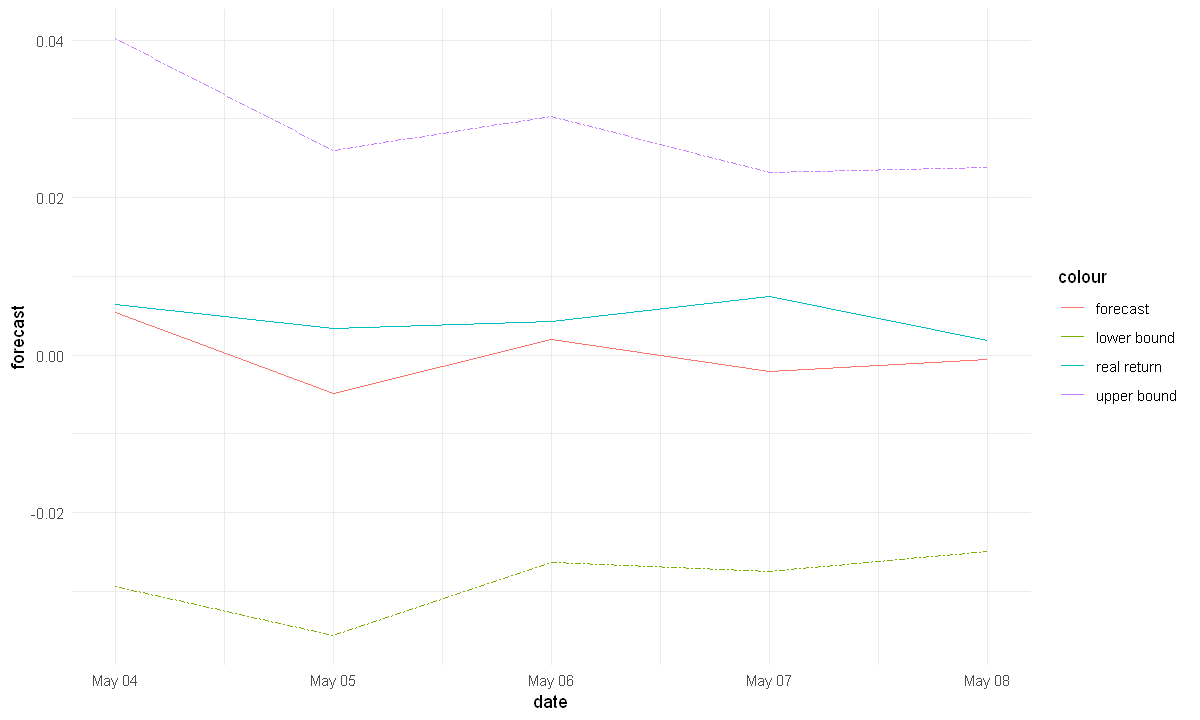

In [205]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(10,6)
ggplot(data = df.est , aes(x=date))+
    geom_line(aes(y = forecast, color = "forecast")) +
    geom_line(aes(y = real.ret, color = "real return")) +
    geom_line(aes(y = lower.ci, color = "lower bound"), linetype = "twodash") +
    geom_line(aes(y = upper.ci, color = "upper bound"), linetype = "twodash") +
    theme(text = element_text(size=15)) + theme_minimal()